# Sketching: Dynamic sketch plane

The sketch is a lightweight, two-dimensional modeler driven primarily by client-side execution.

At any point, the current state of a sketch can be used for operations such as extruding a body,
projecting a profile, or imprinting curves.

The sketch is designed as an effective *functional-style* API with all operations receiving 2D configurations.

For easy reuse of sketches across different regions of your design, you can move a sketch around the
global coordinate system by modifying the plane defining the current sketch location.

This example creates a multi-layer PCB from many extrusions of the same sketch, creating unique
design bodies for each layer.

## Perform required imports

Perform the required imports.

In [1]:
from pint import Quantity

from ansys.geometry.core import Modeler
from ansys.geometry.core.math import UNITVECTOR3D_Z, Point2D
from ansys.geometry.core.misc import UNITS
from ansys.geometry.core.sketch import Sketch

## Define sketch profile

You can create, modify, and plot ``Sketch`` instances independent of supporting
Geometry service instances.

To define the sketch profile for the PCB, you create a sketch outline of individual
``Segment`` and ``Arc`` objects with two circular through-hole attachment points added
within the profile boundary to maintain a single, closed sketch face.

Create a single ``Sketch`` instance to use for multiple design operations.

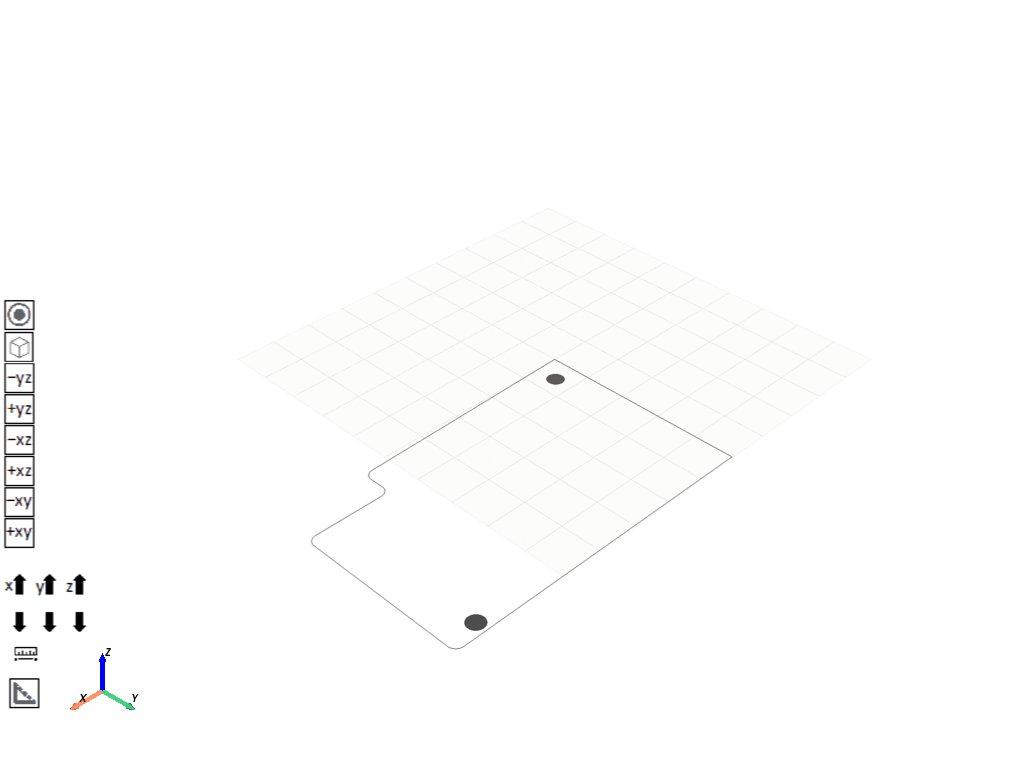

In [2]:
sketch = Sketch()

(
    sketch.segment(Point2D([0, 0], unit=UNITS.mm), Point2D([40, 1], unit=UNITS.mm), "LowerEdge")
      .arc_to_point(Point2D([41.5, 2.5], unit=UNITS.mm), Point2D([40, 2.5], unit=UNITS.mm), tag="SupportedCorner")
      .segment_to_point(Point2D([41.5, 5], unit=UNITS.mm))
      .arc_to_point(Point2D([43, 6.5], unit=UNITS.mm), Point2D([43, 5], unit=UNITS.mm), True)
      .segment_to_point(Point2D([55, 6.5], unit=UNITS.mm))
      .arc_to_point(Point2D([56.5, 8], unit=UNITS.mm), Point2D([55, 8], unit=UNITS.mm))
      .segment_to_point(Point2D([56.5, 35], unit=UNITS.mm))
      .arc_to_point(Point2D([55, 36.5], unit=UNITS.mm), Point2D([55, 35], unit=UNITS.mm))
      .segment_to_point(Point2D([0, 36.5], unit=UNITS.mm))
      .segment_to_point(Point2D([0, 0], unit=UNITS.mm))
      .circle(Point2D([4, 4], UNITS.mm), Quantity(1.5, UNITS.mm), "Anchor1")
      .circle(Point2D([51, 34.5], UNITS.mm), Quantity(1.5, UNITS.mm), "Anchor2")
)

sketch.plot()

## Extrude multiple bodies

Establish a server connection and use the single sketch profile to extrude the board profile
at multiple Z-offsets. Create a named selection from the resulting list of layer bodies.

Note that translating the sketch plane prior to extrusion is more effective (10 server calls)
than creating a design body on the supporting server and then translating the body on the
server (20 server calls).

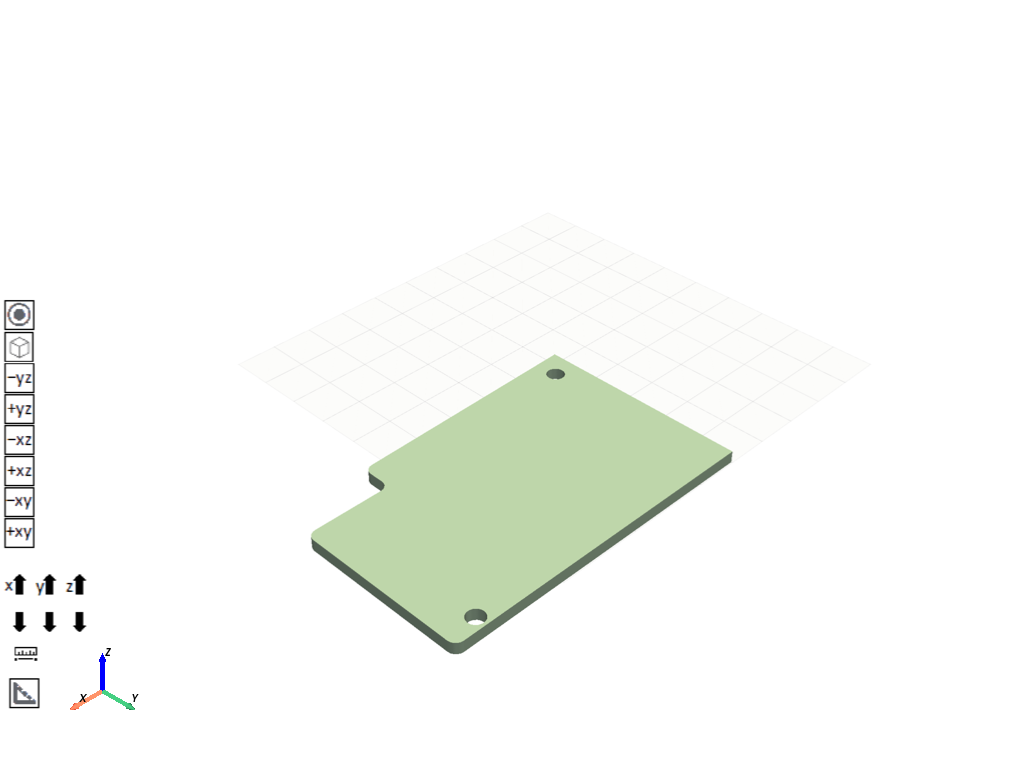

In [3]:
modeler = Modeler()
design = modeler.create_design("ExtrudedBoardProfile")

layers = []
layer_thickness = Quantity(0.20, UNITS.mm)
for layer_index in range(10):
    layers.append(design.extrude_sketch(f"BoardLayer_{layer_index}", sketch, layer_thickness))
    sketch.translate_sketch_plane_by_distance(UNITVECTOR3D_Z, layer_thickness)

board_named_selection = design.create_named_selection("FullBoard", bodies=layers)
design.plot()